In [1]:
import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statistics import mode 



In [15]:
# imports
import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from imblearn.under_sampling import RandomUnderSampler
from GestureRecognitionModel import GestureRecognitionModel

gestures_to_use = ["ClosedHand", "Neutral", "OpenHand", 
                "WristSupination", "WristPronation",
                "ThumbAbduction", "ThumbAdduction",
                "Pinch", "Lateral", "Tripod", "Point"]   # "Pinch", "Lateral", "Tripod", "Point"
individual = True
version = "v2"

# load dataset 
df = pd.read_csv(f"../data/features_{version}.csv")
#df = df[df.gesture.isin(gestures_to_use)]
subjects = list(df.subject.unique())
if "Mario" in subjects:
    subjects.remove("Mario")
if "Hanaa" in subjects:
    subjects.remove("Hanaa")

if not individual:
    subjects_to_remove = ["Mario", "Hanaa"]
    df_train = df[df["take"] != 3]
    df_train = df_train[~df_train.subject.isin(subjects_to_remove)]
    df_test = df[df["take"] == 3]
    
    gestures = df_train.gesture.unique()
    gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
    int_to_gesture = {val:key for key, val in gesture_to_int.items()}
    features_to_keep = df_train.columns[:-4]
    X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]

    # train xgb model 
    model = GestureRecognitionModel("xgboost")
    model.train(X_train,y_train)

# for each subject 
for subject in tqdm([subjects[0]]):
    
    if individual:
        df_sub = df[df.subject == subject]
        # train test split 
        df_train = df_sub[df_sub["take"] != 3]
        df_test = df_sub[df_sub["take"] == 3]
        
        gestures = df_train.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}
        features_to_keep = df_train.columns[:-4]
        X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
        X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
        rus = RandomUnderSampler()
        X_test, y_test = rus.fit_resample(X_test, y_test)

        # train xgb model 
        model = GestureRecognitionModel("xgboost")
        model.train(X_train,y_train)

    else:
        df_sub = df_test[df_test.subject == subject]
        X_test, y_test = df_sub[features_to_keep], [gesture_to_int[gesture] for gesture in df_sub.gesture]
        rus = RandomUnderSampler()
        X_test, y_test = rus.fit_resample(X_test, y_test)





100%|██████████| 1/1 [00:17<00:00, 17.60s/it]


In [16]:
accuracy = dict()

for gesture in df_test.gesture.unique():
    print(gesture)
    accumulate = None
    df_sub_gesture = df_test[df_test.gesture == gesture]
    for timestamp in df_sub_gesture.timestamp.unique():
        df_sub_time = df_sub_gesture[df_sub_gesture.timestamp == timestamp]
        X_test = df_sub_time[features_to_keep]
        preds = model.predict(X_test)
        acc = (preds==gesture_to_int[gesture])
        acc = np.array([int(i) for i in acc])
        if accumulate is None:
            accumulate = acc
            size = len(accumulate)
        if len(acc) < size:
            accumulate = accumulate[:len(acc)]
            size = len(accumulate)
        
        accumulate += np.array(acc[:size])
    accuracy[gesture] = accumulate

hand_close
hand_neutral
hand_open
lateral
pinch
point
thumb_abd
thumb_add
tripod
wrist_pron
wrist_supin


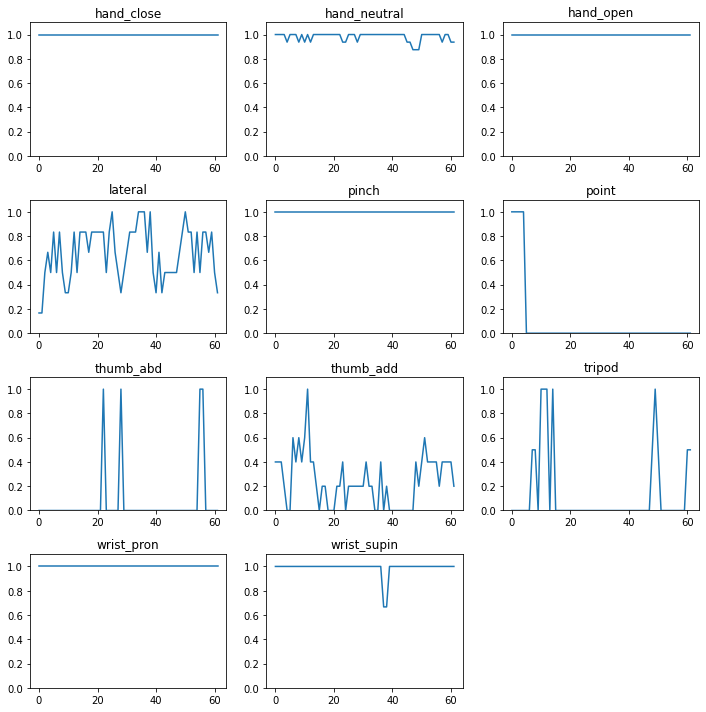

In [17]:
plt.figure(figsize=(10,10))
for i, gesture in enumerate(accuracy):
    plt.subplot(4,3, i+1)
    factor = max(accuracy[gesture])
    plt.plot(accuracy[gesture]/factor)
    plt.ylim((0, 1.1))
    plt.title(gesture)
plt.tight_layout()

In [14]:
model.evaluate(X_test, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [3421, 62]

In [3]:
open_close = False

In [4]:
df = pd.read_csv("data/features_v2.csv")
#df = df[~df["subject"].isin(["David", "Hanaa", "Ester"])]
#df = df[df["subject"].isin(["Santi", "Santi2"])]
if open_close:
    df = df[df["gesture"].isin(["rest", "thumb_abd", "thumb_add"])]

df.head()

,mav_0,mav_1,mav_2,mav_3,mav_4,mav_5,mav_6,mav_7,rms_0,rms_1,...,iatd_2,iatd_3,iatd_4,iatd_5,iatd_6,iatd_7,gesture,subject,take,timestamp
0,4.90,6.54,5.66,15.72,51.84,13.82,18.44,5.50,6.230570,8.379737,...,1349.0,3981.0,12263.0,3460.0,4969.0,1388.0,hand_close,Raj,1,2023-06-29T21-24-13
1,5.00,6.50,5.66,15.94,48.24,16.76,19.04,5.60,6.299206,8.331867,...,1296.0,4159.0,10162.0,3725.0,4080.0,1530.0,hand_close,Raj,1,2023-06-29T21-24-13
2,4.86,5.94,5.36,17.28,48.42,17.62,21.08,5.70,5.991661,7.468601,...,1149.0,3914.0,9994.0,4132.0,4774.0,1555.0,hand_close,Raj,1,2023-06-29T21-24-13
3,4.80,6.64,5.60,18.34,50.10,17.84,21.14,6.26,6.082763,8.212186,...,1194.0,3998.0,10000.0,4293.0,5089.0,1503.0,hand_close,Raj,1,2023-06-29T21-24-13
4,4.76,6.94,5.76,18.82,46.68,18.62,23.12,6.62,6.033241,8.355836,...,1092.0,3970.0,9709.0,4320.0,5384.0,1502.0,hand_close,Raj,1,2023-06-29T21-24-13


In [6]:
df["take"].value_counts()

3    4058
1    2175
Name: take, dtype: int64

In [4]:
gestures = df.gesture.unique()
gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
int_to_gesture = {val:key for key, val in gesture_to_int.items()}


In [5]:
df_train = df[df["take"]!=2]
df_test = df[df["take"]==2]

In [6]:
features_to_keep = df.columns[:-4]
X, y = df[features_to_keep], [gesture_to_int[gesture] for gesture in df.gesture]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [8]:
X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]


In [9]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [10]:
model.score(X_test, y_test)

0.5636913872269376

In [11]:
preds = model.predict(X_test)

def smooth(arr, size):
    arr = list(arr)
    arr = ([arr[0]]*(size//2)) + arr
    arr.extend([arr[-1]]*(size//2))
    output = []
    for i in range(size//2,len(arr) - (size//2)):
        output.append(mode(arr[i-(size//2) :i+(size//2)]))
    return np.array(output)

preds_s = smooth(preds, 20)
sum(preds_s==y_test)/len(preds)

0.6112077361903436

In [12]:
int_to_gesture

{0: 'ClosedHand',
 1: 'Lateral',
 2: 'Neutral',
 3: 'OpenHand',
 4: 'Pinch',
 5: 'Point',
 6: 'ThumbAbduction',
 7: 'ThumbAdduction',
 8: 'Tripod',
 9: 'WristPronation',
 10: 'WristSupination'}

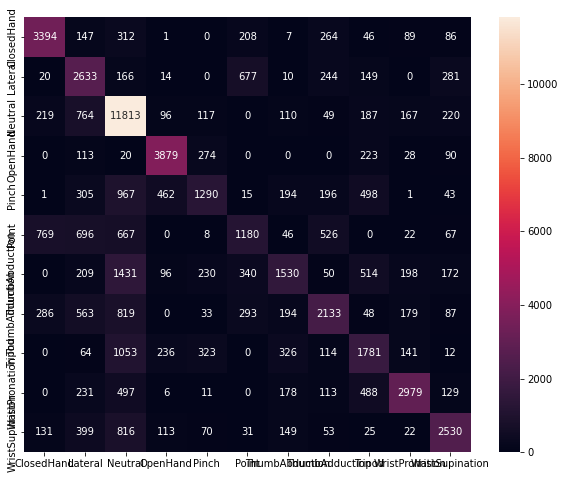

Accuracy: 0.6112077361903436


In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cf_matrix = confusion_matrix(y_test, preds_s)
plt.figure(figsize = (10, 8))
sns.heatmap(cf_matrix, annot=True, fmt=".0f")
int_to_gesture = {i:gesture for gesture, i in gesture_to_int.items()}
plt.yticks(np.arange(0.5,11, 1), [int_to_gesture[i] for i in range(len(int_to_gesture))])
plt.xticks(np.arange(0.5,11, 1), [int_to_gesture[i] for i in range(len(int_to_gesture))])
plt.show()
print(f"Accuracy: {sum(preds_s==y_test)/len(preds)}")

In [107]:
model.save_model('xgb_open_close_v1.json')

In [73]:
loaded = XGBClassifier()
loaded.load_model("xgb_v1.json")
loaded.score(X_test, y_test)

0.9189863445378151

In [111]:
import json 
with open("gesture_to_int_open_close.json", 'w') as f:
    json.dump(gesture_to_int, f)



In [112]:
import json 
with open("int_to_gesture_open_close.json", 'w') as f:
    json.dump(int_to_gesture, f)